# 生成した乱数の確率分布

C++で生成した乱数列のファイル
- `result/uni`: U(0,1)
- `result/norm`: N(0,1)
- `result/exp`: Exp(1)
- `result/pow`: Pow(0.5,1) (alpha,xmin)

これらを下記コマンドで1つのファイル `result/rand_arrays` にまとめた．

```sh
$ cd result
$ echo "uni,norm,exp,pow" > rand_arrays.csv
$ paste -d, uni norm exp pow >> rand_arrays.csv
$ head -n5 rand_arrays.csv 
uni,norm,exp,pow
0.997185,0.263432,0.855473,1.39089
0.932557,-0.229653,0.637446,2.93768
0.128124,3.00901,0.772468,4.23051
0.999041,-0.922904,1.07197,1.25043
```

各乱数列について，CDFとPDFを描画する．

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# comment out below
import json
def dict2rc(dict): return {f'{k1}.{k2}': v for k1,d in dict.items() for k2, v in d.items()}
with open('mpl_rc.json') as f:
    plt.rcParams.update(dict2rc(json.load(f)))
plt.style.use('dracula')

In [36]:
rand_arrays = pd.read_csv('../result/rand_arrays.csv')
display(rand_arrays)

,uni,norm,exp,pow
0,0.446222,0.683451,0.683434,1.04769
1,0.873387,-0.390008,1.245400,1.13632
2,0.086434,-0.422803,0.784141,1.85541
3,0.723602,-0.344287,0.575117,29.86460
4,0.350478,-0.965837,0.876290,1.26831
...,...,...,...,...
999995,0.127409,-1.786460,2.412740,38.18360
999996,0.350782,0.262305,2.733560,1.20722
999997,0.395151,-0.680812,0.172404,2.04398
999998,0.478488,0.903632,1.395730,1.27003


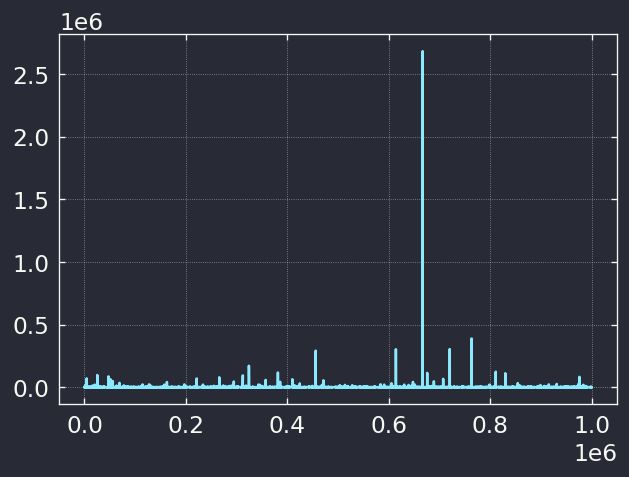

In [37]:
plt.plot(rand_arrays['pow'])

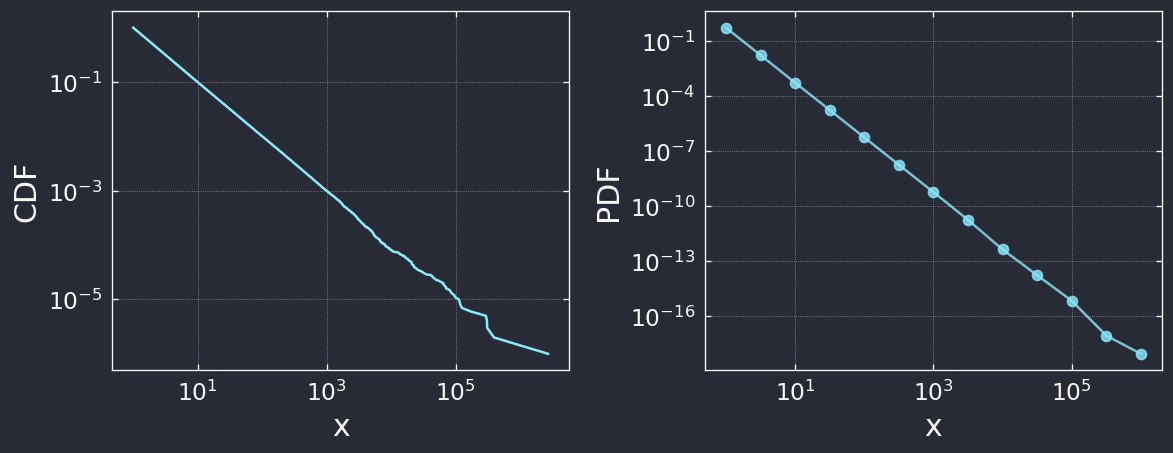

In [58]:
def draw_cdf(xs, ax=None, set_xlabel=True, set_ylabel=True, xlog=True, ylog=True, title=None):
    if not ax: return
    n = len(xs)
    cdf = [(i+1)/n for i in range(n)]
    ax.plot(sorted(xs, reverse=True), cdf)
    if set_xlabel: ax.set_xlabel('x')
    if set_ylabel: ax.set_ylabel('CDF')
    if xlog: ax.set_xscale('log')
    if ylog: ax.set_yscale('log')
    if title: ax.set_title(title)
    
    
def draw_pdf_log(xs, ax=None, set_xlabel=True, set_ylabel=True, 
                 xlog=True, ylog=True, title=None, xmin=None, 
                 dx=1.0, kind='line', alpha=1.0):
    # xs  : データの１次元配列
    # xmin: ヒストグラムの左端の点（Noneなら xs の最小値を使う）
    # dx  : bin幅

    if not ax: return

    pdf = (np.log10(xs) / dx).astype(int).value_counts(normalize=True).sort_index()
    pdf /= np.float_power(10, pdf.index + dx/2) - np.float_power(10, pdf.index - dx/2) # dx
    x = np.float_power(10, pdf.index * dx)

    if kind == 'line':
        ax.plot(x, pdf, marker='o', alpha=alpha)
    
    if set_xlabel: ax.set_xlabel('x')
    if set_ylabel: ax.set_ylabel('PDF')
    if xlog: ax.set_xscale('log')
    if ylog: ax.set_yscale('log')
    if title: ax.set_title(title)


_, axes = plt.subplots(1, 2, figsize=(10,4))
draw_cdf(rand_arrays['pow'], ax=axes[0])
draw_pdf_log(rand_arrays['pow'], ax=axes[1], dx=0.5, kind='line', alpha=0.8)
plt.tight_layout()

## 四分位数を計算

In [61]:
rand_arrays['pow'].quantile([0.25, 0.50, 0.75])

0.25    1.33389
0.50    2.00034
0.75    3.98719
Name: pow, dtype: float64

## ベキ分布のパラメータを最尤法で求める

$x_{min}$ を所与のものとして，ベキ指数 $\alpha$ を最尤法で求める．

$$\alpha = \Big( \langle \log x \rangle - \log x_{min} \Big)^{-1}$$

where

$$\langle \log x \rangle = \frac{1}{N}\sum_{i=1}^N \log x_i$$

In [62]:
def calc_pow_exp(pow_array, xmin=1):
    xmin = 1 # given
    alpha = np.mean(np.log(pow_array)) - np.log(xmin)
    return alpha

calc_pow_exp(rand_arrays['pow'])

0.9992374904123352